In [78]:
import argparse, os
import numpy as np, ephem
from numpy.lib import recfunctions
from pixell import utils, enmap, bunch, reproject, colors, coordinates, mpi
from scipy import interpolate, optimize
import glob
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import h5py
from datetime import datetime

import matplotlib.dates as mdates

import petroff_colormap

import pickle as pk
import pandas as pd
from astroquery.jplhorizons import Horizons
from astropy.time import Time
import ephem
import scipy.signal as signal
from palettable.colorbrewer.sequential import Blues_9
from scipy.stats import binned_statistic
from statistics import mean
import seaborn as sns
import sys

from asteroid_utils_pixell import minorplanet, get_desig, QueryHorizons, compute_alpha, get_index, inv_var

%load_ext autoreload
%autoreload 2
sns.set_theme(style='ticks')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

from mpl_toolkits.axes_grid1 import AxesGrid

import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [3]:
def get_theory(name, freq):
    with open("/gpfs/fs1/home/r/rbond/ricco/minorplanets/normalized_theory_flux_dict.pk", 'rb') as f:
        '''
        Format: [f090, f150, f220]
        '''
        normalized_theory_flux_dict = pk.load(f)

    try:
        if freq == "f090":
            return normalized_theory_flux_dict[name]["run5a"][0]
        elif freq == "f150":
            return normalized_theory_flux_dict[name]["run5a"][1]
        elif freq == "f220":
            return normalized_theory_flux_dict[name]["run5a"][2]
        else:
            print("Not a valid frequency, please try again")

    except KeyError:
        print("Object " + name + " not currently in flux theory file")   

In [4]:
def one_lcurve(name, arr, freq, directory = None, show = False, pickle = False):
    '''
    Inputs:
    name, type: string, name of object we want
    arr, type: string, ACT array we want
    freq, type: string, frequency band
    directory, type: string, optionally save plots in specified directory
    show, type: boolean, optionally display plot right after calling one_lcurve()
    pickle, type: boolean, optionally pickle file after generating light curve

    Output:
    Single nighttime light curve for desired object with SPT-like F weighting
    '''

    index = get_index(name)

    #get ref flux
    ref_flux = get_theory(name, freq)
    print(ref_flux)     

    #Jack's maps
    path = "/scratch/r/rbond/jorlo/actxminorplanets/sigurd/asteroids/" + name

    #get rho, kappa, info files
    rho_files = glob.glob(path + "/*" + arr + "_" + freq + "_" + "rho.fits")
    kap_files = [utils.replace(r, "rho.fits", "kappa.fits") for r in rho_files]
    info_files = [utils.replace(r, "rho.fits", "info.hdf") for r in rho_files]

    if ref_flux is None:
        len(rho_files) == 0

    if len(rho_files) != 0:
        #find time
        str_times = []
        t_start = len(path) + len(name) + 9
        t_end = t_start + 10
        for time in rho_files:
            str_times.append(time[t_start:t_end])
        int_times = [int(t) for t in str_times]
        start = Time(min(int_times), format='unix')
        end = Time(max(int_times), format='unix')    
        start_iso = start.iso
        end_iso = end.iso

    #get astroquery data to create line of best fit
    obj_earth = Horizons(id=name, location='W99', epochs={'start':start_iso, 'stop':end_iso, 'step':'1d'},id_type='asteroid_name')
    eph = obj_earth.ephemerides()

    el = obj_earth.elements()
    print(el['period'])

    time = eph['datetime_jd']
    mjd_times = utils.jd2mjd(time)    
    delta_earth_best = eph['delta'] #earth-asteroid distance
    delta_sun_best = eph['r'] #sun-asteroid distance
    alpha_best = eph['alpha'] 

    try:
        best_F = (delta_earth_best**(-2) * delta_sun_best**(-1/2)*10**(-0.004*alpha_best)) * ref_flux
    except TypeError:
        pass

    flux_data = []
    err_data = []
    times_data = []

    night_times = []    
    Fs = []

    for count, t in enumerate(int_times):      
        #get info
        info = bunch.read(info_files[count])
        ctime0 = np.mean(info.period)

        hour = (ctime0/3600) % 24

        #daytime maps
        if (11 < hour < 23):
            continue

        #nighttime maps
        else:      
            #convert time
            time_temp = Time(t, format='unix')
            time_iso = time_temp.iso
            eph_table = Horizons(id=name, location='W99', epochs={time_iso}, id_type='asteroid_name')
            tables = eph_table.ephemerides()

            #get instantaneous ephemerides
            r_ast = tables['delta'][0] #earth-asteroid distance
            ra_ast = tables['RA'][0]
            dec_ast = tables['DEC'][0]
            d_earth = tables['delta'][0] #earth-asteroid distance
            d_sun = tables['r'][0] #sun-asteroid distance

            #find sun angle using vectors
            cur_time = Time(ctime0/86400. + 40587.0, format = 'mjd')

            sun = ephem.Sun()
            sun.compute(cur_time.utc.iso)

            #vectors        
            v_ea = utils.ang2rect([ra_ast*utils.degree, dec_ast*utils.degree])*r_ast
            v_es = utils.ang2rect([sun.ra, sun.dec])*sun.earth_distance
            sunang = utils.vec_angdist(-v_ea, -v_ea+v_es) / utils.degree

            #F weights
            try:
                F_weight = (d_earth**(-2) * d_sun**(-1/2)*10**(-0.004*sunang)) * ref_flux
            except:
                pass                             

            #get data
            kappa = enmap.read_map(kap_files[count])
            rho = enmap.read_map(rho_files[count])

            #cut bad maps       
            tol = 1e-2
            r = 5
            mask = kappa > np.max(kappa)*tol
            mask = mask.distance_transform(rmax=r) >= r 
            rho *= mask
            kappa *= mask

            if kappa[0,:,:].at([0,0]) <= 1e-9:
                continue         
            else:        
                #get flux, error, and time
                flux = rho / kappa 
                good_flux = flux[0].at([0, 0])
                flux_data.append(good_flux)

                err = np.abs(kappa)**(-0.5) 
                err_data.append(err[0].at([0,0]))

                night_times.append(t)
                Fs.append(F_weight)          

    night_mjd = utils.ctime2mjd(night_times)

    plt.clf()
    plt.errorbar(night_mjd, flux_data, yerr=err_data, fmt='o', label='Obs', zorder=0)#capsize=4, 
    plt.scatter(night_mjd, Fs, label='Theory', c='r', zorder=1)
    plt.plot(mjd_times, best_F, label='F weighting', ls='--', color=Blues_9.hex_colors[-2])
    plt.fill_between(mjd_times, 0.95*best_F, 1.05*best_F, label='95% uncertainty', fc=Blues_9.hex_colors[-2], alpha=0.4)
    plt.xlabel("Time (MJD)")
    plt.ylabel("Flux (mJy)")
    plt.legend(loc = 'best')
    plt.title("Light curve of {name} on {arr} at {freq}".format(name=name, arr=arr, freq=freq))         

    if show is not False:
        plt.show()

    if directory is not None:
        plt.savefig(directory + "{name}_light_curve_{arr}_{freq}.pdf".format(name=name, arr=arr, freq=freq))

    if pickle is not False:
        data_dict = {'Name': name, 'Array': arr, 'Frequency': freq, 'Flux': flux_data, 'F': Fs, 'Time': night_mjd, 'Error': err_data, 'Ref Flux': ref_flux, 'astroq F weight': best_F, 'astroq Times': mjd_times}
        filename = "/gpfs/fs1/home/r/rbond/ricco/minorplanets/asteroids/light_curves/lcurve_data_" + name + "_" + freq +".pk"
        outfile = open(filename, 'wb')
        pk.dump(data_dict, outfile)
        outfile.close()

    else:
        print("No hits")   

In [7]:
name = 'Vesta'

with open('asteroids.pk', 'rb') as f:
        #open the pickle that contains all this info. You can also do this via querries to MPL but there's no 
        #internet on compute nodes so I saved all the relevant stuff
        df = pk.load(f)

#Find the index (not MPL designation) where the asteroid name array == name
idx = np.where((df['name'] == name))[0]

#Return the designation by indexing the designation array at the same spot
desig = df['designation'][idx]
print(desig)

0    4
Name: designation, dtype: object


In [8]:
desig, name, semimajor = get_desig(0)
print(name)

ast = minorplanet(name, semimajor)



Vesta


In [9]:
with open('./pks/sups.pk', 'rb') as f:
    sups = pk.load(f)
sups = sups[name] #Just keep our sups

## Prep Lightcurves

In [10]:
#get f090
infile_f090 = open("/gpfs/fs1/home/r/rbond/ricco/minorplanets/asteroids/light_curves/lcurve_data_" + name +"_all_f090.pk", 'rb')
dict_f090 = pk.load(infile_f090)
infile_f090.close()

#get f150
infile_f150 = open("/gpfs/fs1/home/r/rbond/ricco/minorplanets/asteroids/light_curves/lcurve_data_" + name +"_all_f150.pk", 'rb')
dict_f150 = pk.load(infile_f150)
infile_f150.close()

#get f220
infile_f220 = open("/gpfs/fs1/home/r/rbond/ricco/minorplanets/asteroids/light_curves/lcurve_data_" + name +"_all_f220.pk", 'rb')
dict_f220 = pk.load(infile_f220)
infile_f220.close()

names = dict_f090['Name']  

#get times, fluxs, Fs, errors
times_f090 = dict_f090['Time']
flux_f090 = dict_f090['Flux']
fWeights_f090 = dict_f090['F']
error_f090 = dict_f090['Error']
ref_F_weight_f090 = dict_f090['astroq F weight']
fit_times_f090 = dict_f090['astroq Times']

times_f150 = dict_f150['Time']
flux_f150 = dict_f150['Flux']
fWeights_f150 = dict_f150['F']
error_f150 = dict_f150['Error']
ref_F_weight_f150 = dict_f150['astroq F weight']
fit_times_f150 = dict_f150['astroq Times']

times_f220 = dict_f220['Time']
flux_f220 = dict_f220['Flux']
fWeights_f220 = dict_f220['F']
error_f220 = dict_f220['Error']
ref_F_weight_f220 = dict_f220['astroq F weight']
fit_times_f220 = dict_f220['astroq Times']  

interp_ref_F_weight_f090 = interpolate.interp1d(fit_times_f090, ref_F_weight_f090, fill_value = 'extrapolate')
interp_ref_F_weight_f150 = interpolate.interp1d(fit_times_f150, ref_F_weight_f150, fill_value = 'extrapolate')
interp_ref_F_weight_f220 = interpolate.interp1d(fit_times_f220, ref_F_weight_f220, fill_value = 'extrapolate')

fit_times_f090 = np.linspace(min(times_f090), max(times_f090), int(1e5))
fit_times_f150 = np.linspace(min(times_f150), max(times_f150), int(1e5))
fit_times_f220 = np.linspace(min(times_f220), max(times_f220), int(1e5))

interp_ref_F_weight_f090 = interp_ref_F_weight_f090(fit_times_f090)
interp_ref_F_weight_f150 = interp_ref_F_weight_f150(fit_times_f150)
interp_ref_F_weight_f220 = interp_ref_F_weight_f220(fit_times_f220)




In [11]:
ast.make_all_stacks(weight_type = 'spt', plot = False, verbose = False, weight_debug = False)

Flux dict written for  Vesta


/tmp/ipykernel_109129/587034897.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Oranges', color_res)
/tmp/ipykernel_109129/587034897.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Blues_r', color_res)
/tmp/ipykernel_109129/587034897.py:31: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  cm.register_cmap('OrangeBlue', cmap = ListedColormap(newcolors))
/tmp/ipykernel_109129/587034897.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated 

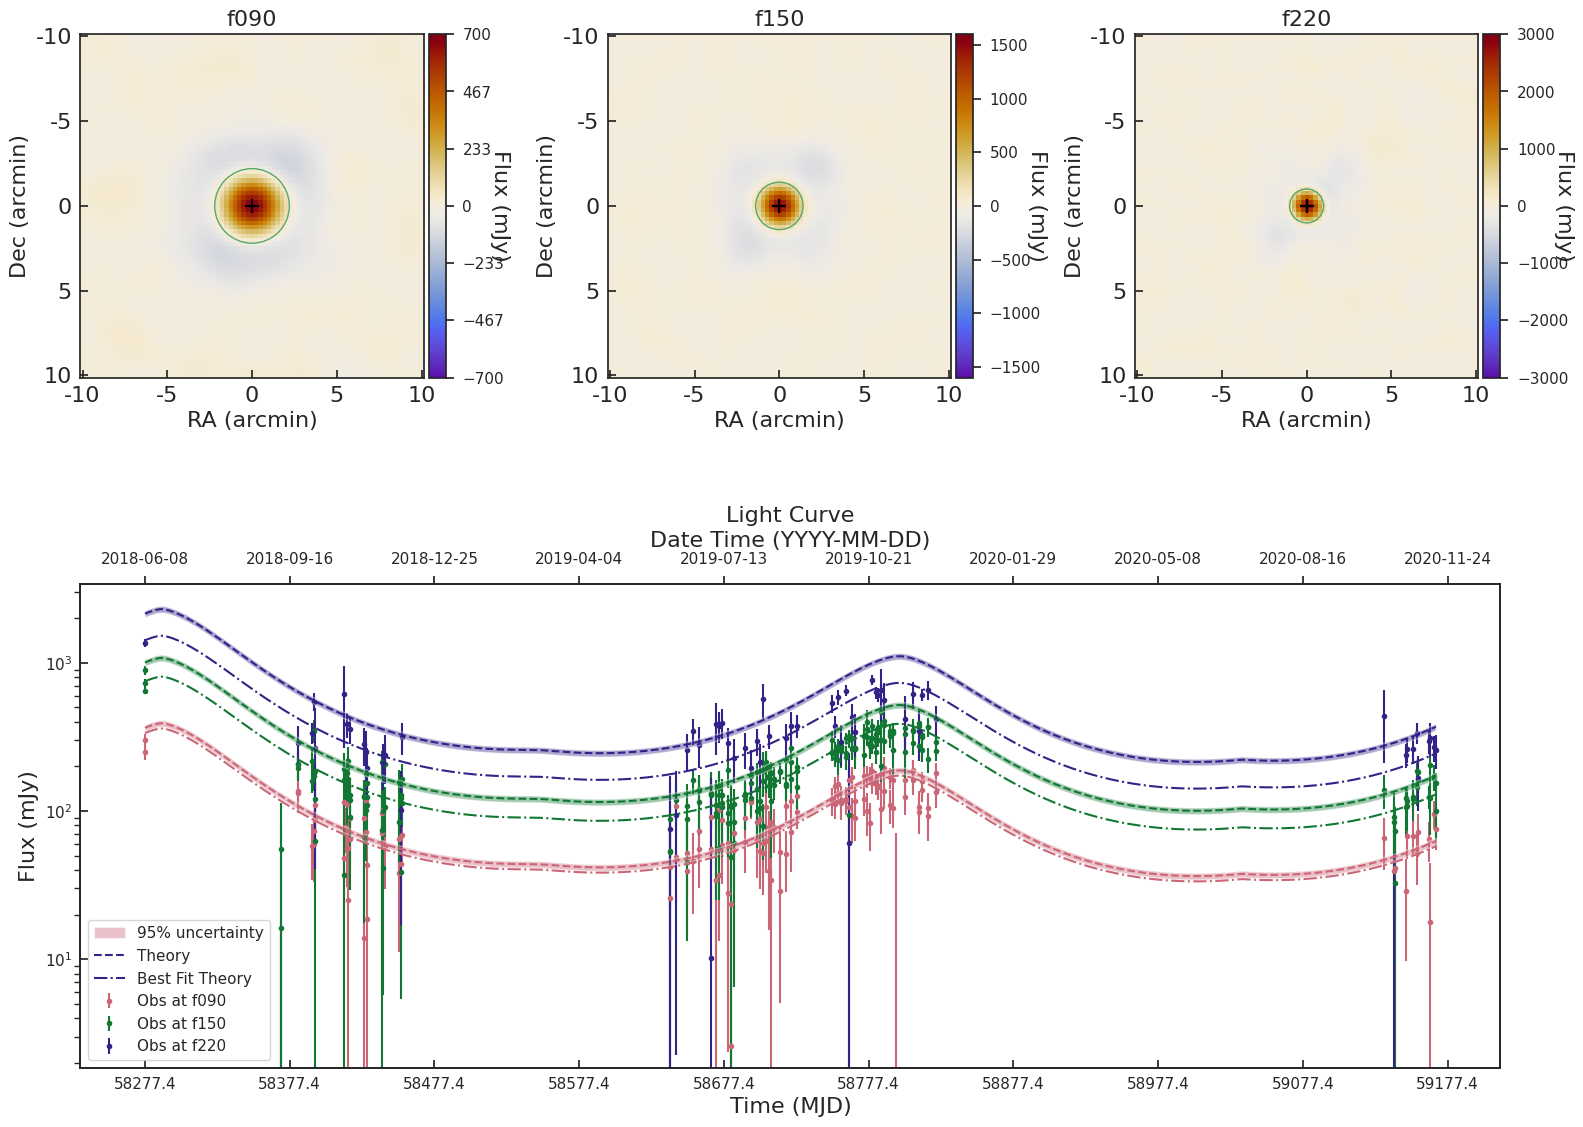

In [12]:
from palettable.cartocolors.qualitative import Safe_10

colors = np.array(Safe_10.colors)/256

fontsize = 16
fig = plt.figure(figsize=(16, 12))
ax090= fig.add_subplot(2,3,1)
ax150= fig.add_subplot(2,3,2)
ax220= fig.add_subplot(2,3,3)
axlc = fig.add_subplot(2,1,2)

'''
fig = plt.figure()
axlc = plt.subplot2grid((2, 3), (1, 0), colspan=3)
ax090 = plt.subplot2grid((2, 3), (0, 0))
ax150 = plt.subplot2grid((2, 3), (0, 1))
ax220 = plt.subplot2grid((2, 3), (0, 2))
'''

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.cm as cm

color_res = 516

bottom = cm.get_cmap('Oranges', color_res)
top = cm.get_cmap('Blues_r', color_res)
newcolors = np.vstack((top(np.linspace(0, 1, color_res)),bottom(np.linspace(0, 1, color_res))))

from matplotlib.colors import ListedColormap
cm.register_cmap('OrangeBlue', cmap = ListedColormap(newcolors))
cmap = 'OrangeBlue'

#orbl_cmap = cm.get_cmap('OrangeBlue')
orbl_cmap = cm.get_cmap('class')

#########################################################
#                       090                             #
#########################################################
ax090.tick_params(direction='in')

var_map_pa5 = ast.map_dict['night']['pa5']['090']['flux'] / ast.map_dict['night']['pa5']['090']['snr']
var_map_pa6 = ast.map_dict['night']['pa6']['090']['flux'] / ast.map_dict['night']['pa6']['090']['snr']

freq_map, noise = inv_var([ast.map_dict['night']['pa5']['090']['flux'], ast.map_dict['night']['pa6']['090']['flux']],
                  [var_map_pa5, var_map_pa6])

#mid = 1-np.amax(freq_map)/(np.amax(freq_map) + abs(np.amin(freq_map)))
#orig_cmap = cm.coolwarm

#shifted_cmap = shiftedColorMap(orbl_cmap, midpoint=mid, name='shifted')

map_max = roundup(np.amax(freq_map))
im_090 = ax090.imshow(freq_map, cmap=orbl_cmap, vmin=-map_max, vmax=map_max)
ax090.set_title('f090', size = fontsize)

divider = make_axes_locatable(ax090)
cax = divider.append_axes('right', size='5%', pad=0.05)

cbar = fig.colorbar(im_090, cax=cax, ticks=np.linspace(-map_max, map_max, 7))
cbar.set_label('Flux (mJy)', rotation=270, size = fontsize)

ax090.xaxis.set_ticks(np.arange(0, 100, 20))
ax090.yaxis.set_ticks(np.arange(0, 100, 20))

labels = [-10, -5, 0, 5, 10]
ax090.set_xticklabels(labels, size = fontsize)
ax090.set_yticklabels(labels, size = fontsize)


ax090.set_xlabel('RA (arcmin)', size = fontsize)
ax090.set_ylabel('Dec (arcmin)', size = fontsize)

ax090.scatter(40,40, marker = '+', color = 'black', s=100)
circle = plt.Circle((40, 40), 2.2/0.25, color = 'g',fill=False, alpha = 1)
ax090.add_patch(circle)


#########################################################
#                       150                             #
#########################################################
ax150.tick_params(direction='in')

var_map_pa4 = ast.map_dict['night']['pa4']['150']['flux'] / ast.map_dict['night']['pa4']['150']['snr']
var_map_pa5 = ast.map_dict['night']['pa5']['150']['flux'] / ast.map_dict['night']['pa5']['150']['snr']
var_map_pa6 = ast.map_dict['night']['pa6']['150']['flux'] / ast.map_dict['night']['pa6']['150']['snr']

flux_map_pa4 = ast.map_dict['night']['pa4']['150']['flux']
flux_map_pa5 = ast.map_dict['night']['pa5']['150']['flux']
flux_map_pa6 = ast.map_dict['night']['pa6']['150']['flux']

freq_map, noise = inv_var([flux_map_pa4, flux_map_pa5, flux_map_pa6],
                  [var_map_pa4, var_map_pa5, var_map_pa6])

#mid = 1-np.amax(freq_map)/(np.amax(freq_map) + abs(np.amin(freq_map)))
#orig_cmap = cm.coolwarm

#shifted_cmap = shiftedColorMap(orbl_cmap, midpoint=mid, name='shifted')

map_max = roundup(np.amax(freq_map))
im_150 = ax150.imshow(freq_map, cmap=orbl_cmap, vmin=-map_max, vmax=map_max)
ax150.set_title('f150', size = fontsize)

divider = make_axes_locatable(ax150)
cax = divider.append_axes('right', size='5%', pad=0.05)

cbar = fig.colorbar(im_150, cax=cax)
cbar.set_label('Flux (mJy)', rotation=270, size = fontsize)

ax150.xaxis.set_ticks(np.arange(0, 100, 20))
ax150.yaxis.set_ticks(np.arange(0, 100, 20))

labels = [-10, -5, 0, 5, 10]
ax150.set_xticklabels(labels, size = fontsize)
ax150.set_yticklabels(labels, size = fontsize)

ax150.set_xlabel('RA (arcmin)', size = fontsize)
ax150.set_ylabel('Dec (arcmin)', size = fontsize)

ax150.scatter(40,40, marker = '+', color = 'black', s=100)
circle = plt.Circle((40, 40), 1.4/0.25, color = 'g',fill=False, alpha = 1)
ax150.add_patch(circle)

#########################################################
#                       220                             #
#########################################################
ax220.tick_params(direction='in')

#mid = 1-np.amax(freq_map)/(np.amax(freq_map) + abs(np.amin(freq_map)))
#orig_cmap = cm.coolwarm

#shifted_cmap = shiftedColorMap(orbl_cmap, midpoint=mid, name='shifted')

#cmap = plt.get_cmap('jet')
cmap = orbl_cmap

map_max = roundup(np.amax(ast.map_dict['night']['pa4']['220']['flux']))
map_min = roundup(np.amin(ast.map_dict['night']['pa4']['220']['flux']))

im_220 = ax220.imshow(ast.map_dict['night']['pa4']['220']['flux'], cmap=cmap, vmin=-map_max, vmax=map_max)
ax220.set_title('f220', size = fontsize)

divider = make_axes_locatable(ax220)
cax = divider.append_axes('right', size='5%', pad=0.05)

cbar = fig.colorbar(im_220, cax=cax)
cbar.set_label('Flux (mJy)', rotation=270, size = fontsize)

ax220.xaxis.set_ticks(np.arange(0, 100, 20))
ax220.yaxis.set_ticks(np.arange(0, 100, 20))

labels = [-10, -5, 0, 5, 10]
ax220.set_xticklabels(labels, size = fontsize)
ax220.set_yticklabels(labels, size = fontsize)

ax220.set_xlabel('RA (arcmin)', size = fontsize)
ax220.set_ylabel('Dec (arcmin)', size = fontsize)

ax220.scatter(40,40, marker = '+', color = 'black', s=100)
circle = plt.Circle((40, 40), 1.0/0.25, color = 'g',fill=False, alpha = 1)
ax220.add_patch(circle)


#########################################################
#                  Light Curves                         #
#########################################################
axlc.tick_params(direction='in')

log_plot = True
    
#f090
axlc.errorbar(times_f090, flux_f090, yerr=error_f090, fmt='.', label='Obs at f090', zorder=0, color=colors[1])
axlc.plot(fit_times_f090, interp_ref_F_weight_f090,  ls='--', color=colors[1])#Blues_9.hex_colors[-2]
axlc.plot(fit_times_f090, interp_ref_F_weight_f090*sups['090'][0], ls='-.', color=colors[1])
axlc.fill_between(fit_times_f090, 0.95*interp_ref_F_weight_f090, 1.05*interp_ref_F_weight_f090, 
                  label='95% uncertainty', fc=colors[1], alpha=0.4)#Blues_9.hex_colors[-2]  

#f150
axlc.errorbar(times_f150, flux_f150, yerr=error_f150, fmt='.', label='Obs at f150', zorder=0, color=colors[3])
axlc.plot(fit_times_f150, interp_ref_F_weight_f150, ls='--', color=colors[3])
axlc.plot(fit_times_f150, interp_ref_F_weight_f150*sups['150'][0], ls='-.', color=colors[3])
axlc.fill_between(fit_times_f150, 0.95*interp_ref_F_weight_f150, 1.05*interp_ref_F_weight_f150, 
                  fc=colors[3], alpha=0.4)  

#f220
axlc.errorbar(times_f220, flux_f220, yerr=error_f220, fmt='.', label='Obs at f220', zorder=0, color=colors[4])
axlc.plot(fit_times_f220, interp_ref_F_weight_f220, ls='--', label='Theory', color=colors[4])
axlc.plot(fit_times_f220, interp_ref_F_weight_f220*sups['220'][0], label = 'Best Fit Theory', 
          ls='-.', color=colors[4])
axlc.fill_between(fit_times_f220, 0.95*interp_ref_F_weight_f220, 1.05*interp_ref_F_weight_f220, 
                  fc=colors[4], alpha=0.4)      

axlc.set_xticks(np.arange(min(times_f220), max(times_f220)+100, 100.0))

axlc.axhline(color='black')

axlc.set_xlabel("Time (MJD)", size = fontsize)
axlc.set_ylabel("Flux (mJy)", size = fontsize)
axlc.legend(loc='best')      
axlc.set_title("Light Curve", size = fontsize)

if log_plot:
    axlc.set_yscale('log')

def conv(time):
    t = Time(time, format='mjd')
    t.format = 'iso'
    t.out_subfmt = 'date'
    return t.value

axlc2 = axlc.twiny()
axlc2.set_xbound(axlc.get_xbound())
axlc2.set_xticks(np.arange(min(times_f220), max(times_f220)+100, 100.0))
axlc2.set_xticklabels([conv(t) for t in axlc.get_xticks()])
axlc2.set_xlabel(r'Date Time (YYYY-MM-DD)', size = fontsize)

#plt.title("Summary Plot for {}".format(name))
plt.tight_layout()
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/summary_plot_{}.pdf'.format(name), dpi=300)
plt.savefig('/home/r/rbond/jorlo/dev/minorplanets/plots/summary_plot_{}.png'.format(name), dpi=300)

plt.show()

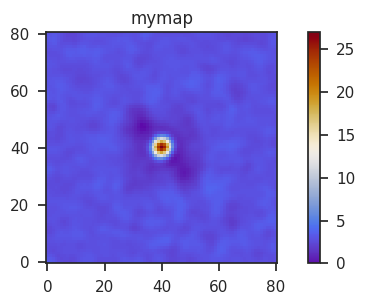

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
import numpy as np


plt.figure(figsize=(8,3))
#cmap = plt.get_cmap('jet')
cmap = orbl_cmap
'''
map_max = roundup(np.amax(ast.map_dict['night']['pa4']['220']['flux']))
map_min = roundup(np.amin(ast.map_dict['night']['pa4']['220']['flux']))

im=plt.imshow(ast.map_dict['night']['pa4']['220']['flux'], cmap=cmap, vmin=-map_max, vmax=map_max)
plt.title('mymap')

vmin = map_min  
vmax = map_max 
'''

# some data between 0 and 27
image = np.random.rand(30,60)*27
image[:,30:] = np.sort(image[:,30:].flatten()).reshape(30,30)

image = ast.map_dict['night']['pa4']['220']['flux']/100

im=plt.imshow(image, interpolation='nearest',origin='lower', cmap=cmap)
#im=plt.imshow(image, interpolation='nearest',origin='lower', cmap=cmap)

plt.title('mymap')

map_max = roundup(np.amax(image))
map_min = roundup(np.amin(image))

vmin = map_min  
vmax = map_max 

#a=round(image.max(),0)

vmin= 0  #minimum value to show on colobar
vmax = 27 #maximum value to show on colobar
norm = matplotlib.colors.Normalize(vmin=vmin, vmax =vmax)
#generate colors from original colormap in the range equivalent to [vmin, vamx] 
colors = cmap(np.linspace(1.-(vmax-vmin)/float(vmax), 1, cmap.N))
# Create a new colormap from those colors
color_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_jet', colors)

# create some axes to put the colorbar to
cax, _  = matplotlib.colorbar.make_axes(plt.gca())
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm,)

#cbar.set_ticks([17,23,a])
#cbar.set_ticklabels([17,23,a])

plt.show()

In [ ]:
cmap.N

In [109]:
name = "Kalliope"
weight_type = "unweighted"
time = "night"
pa = "pa6"
freq = "150"

#with open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/{}_{}_lc_{}_{}_{}.fits'.format(name, weight_type, time, pa, freq), "rb") as f:
    #test = pk.load(f)
fname = "{}_{}_lc_{}_{}_{}.fits".format(name, weight_type, time, pa, freq)
test = fits.open('/scratch/r/rbond/jorlo/actxminorplanets/sigurd/lightcurves/' +fname)

<ErrorbarContainer object of 3 artists>

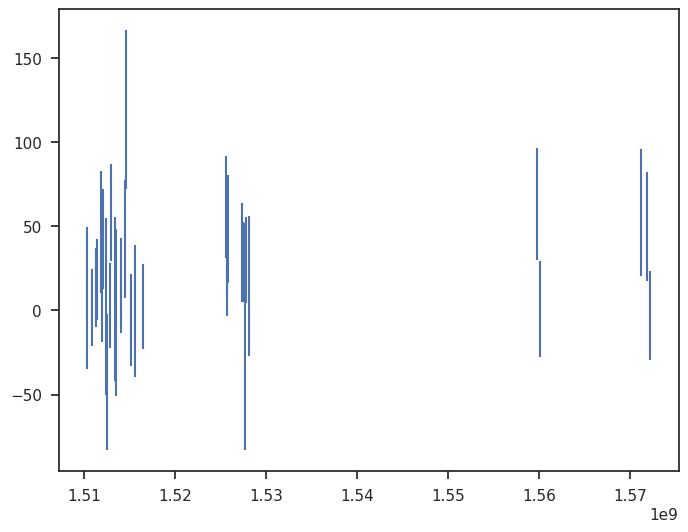

In [110]:
plt.errorbar(test[1].data["Time"], test[1].data["Flux"], yerr = test[1].data["FluxUncertainty"], linestyle = "None")

In [76]:
test[0].data


In [77]:
data

In [88]:
test = fits.open()